In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
import graphviz

In [2]:
df = pd.read_csv('./data/mergeddata.csv')

In [3]:
#dropping columns not related to the models

df.drop(columns = ['Unnamed: 0', 'is_closed', 'coordinates', 'latitude', 'longitude', 'zip_code', 'url', 'transactions', 'location'], inplace = True)

In [4]:
df.head()

,alias,categories,name,rating,review_count,permanently closed,outdoor_seating,price_cat,delivery,restaurant_reservation,pickup,total_restaurants_in_zip,Population Density,distance_to_subway
0,bali-kitchen-new-york-2,Specialty Food,Bali Kitchen,4.5,143,1,0,two,1,0,1,714.0,98998.8,0.214864
1,cafe-triskell-astoria,Breakfast & Brunch,Cafe Triskell,4.5,442,0,0,two,1,0,1,179.0,44344.0,0.160476
2,lucky-strike-new-york-8,"Mobile, Events and Venues",Lucky Strike,3.5,561,1,0,two,0,0,0,672.0,54427.5,0.235412
3,taqueria-tlaxcalli-bronx-3,Mexican,Taqueria Tlaxcalli,4.5,628,0,1,two,1,0,1,155.0,51271.5,0.420375
4,bao-bao-cafe-new-york-3,Chinese,Bao Bao Cafe,4.0,196,0,0,one,1,0,1,52.0,32132.0,0.033868


In [5]:
#binning the transactions into the total number as it worked well in our statistical tests

df['num_transaction'] = df['delivery'] + df['restaurant_reservation'] + df['pickup']
df.drop(columns = ['delivery', 'restaurant_reservation', 'pickup'], inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 12 columns):
alias                       1360 non-null object
categories                  1360 non-null object
name                        1360 non-null object
rating                      1360 non-null float64
review_count                1360 non-null int64
permanently closed          1360 non-null int64
outdoor_seating             1360 non-null int64
price_cat                   1360 non-null object
total_restaurants_in_zip    1360 non-null float64
Population Density          1360 non-null float64
distance_to_subway          1360 non-null float64
num_transaction             1360 non-null int64
dtypes: float64(4), int64(4), object(4)
memory usage: 127.6+ KB


In [7]:
# df.drop(columns = 'outdoor_seating', inplace = True)

In [8]:
#binning ratings into statistically similar categories

df['rating'] = df.rating.apply(lambda x: 3 if x < 3 else x)
df['rating'] = df.rating.apply(lambda x: 5 if x > 4 else x)

In [9]:
#setting variables for modeling and performing a train test split

X = df.drop(columns = ['permanently closed', 'alias', 'name'])
y = df['permanently closed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, stratify = y, random_state = 2)

In [10]:
X_train.shape

(951, 9)

In [11]:
X_test.shape

(409, 9)

In [12]:
y_train.value_counts()

0    820
1    131
Name: permanently closed, dtype: int64

In [13]:
y_test.value_counts()

0    353
1     56
Name: permanently closed, dtype: int64

In [14]:
#breaking out dummy columns in separate dataframes in order to add and subtract as necessary

price_dummies = pd.get_dummies(X_train.price_cat, drop_first=True)
X_train.drop(columns = 'price_cat', inplace=True)

testprice_dummies = pd.get_dummies(X_test.price_cat, drop_first= True)
X_test.drop(columns = 'price_cat', inplace= True)

cat_dummies = pd.get_dummies(X_train.categories, drop_first= True)
X_train.drop(columns= 'categories', inplace = True)

testcat_dummies = pd.get_dummies(X_test.categories, drop_first=True)
X_test.drop(columns= 'categories', inplace = True)

In [15]:
#creating scaled copies of the train and test sets

scale = MinMaxScaler()

X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), columns = X_train.columns)

X_test_scaled = pd.DataFrame(scale.transform(X_test), columns = X_test.columns)

In [16]:
#creating variant sets including all dummy variables

X_train_maxft = pd.concat([X_train.drop(columns = 'Population Density'), price_dummies, cat_dummies], axis = 1)
x_test_maxft = pd.concat([X_test.drop(columns = 'Population Density'), testprice_dummies, testcat_dummies], axis = 1)

In [17]:
#running a recursive feature eliminator to identify any columns not relevant to the model

ols = LogisticRegression()

select = RFECV(estimator = ols, step = 1, cv = 10, scoring = 'recall', verbose = 1, n_jobs=-1)

select.fit(X_train_maxft, y_train)

selected_columns = X_train_maxft.columns[select.support_]
removed_columns = X_train_maxft.columns[~select.support_]

Fitting estimator with 33 features.


In [18]:
removed_columns

Index(['review_count'], dtype='object')

In [19]:
X_train.drop(columns = 'Population Density', inplace= True)
X_test.drop(columns = 'Population Density', inplace= True)

In [20]:
lr = LogisticRegression(random_state=2, class_weight= 'balanced', penalty='l2', C= .8, solver = 'liblinear')

lr.fit(pd.concat([X_train, price_dummies, cat_dummies], axis = 1), y_train)

train_pred = lr.predict(pd.concat([X_train, price_dummies, cat_dummies], axis = 1))
test_pred = lr.predict(pd.concat([X_test, testprice_dummies, testcat_dummies], axis = 1))

print(metrics.accuracy_score(y_train, train_pred))
print(metrics.accuracy_score(y_test, test_pred))

print(metrics.precision_score(y_train, train_pred))
print(metrics.precision_score(y_test, test_pred))

print(metrics.recall_score(y_train, train_pred))
print(metrics.recall_score(y_test, test_pred))

# 0.7939011566771819
# 0.7775061124694377
# 0.39057239057239057
# 0.3643410852713178
# 0.8854961832061069
# 0.8392857142857143 before removing outdoor seating

0.7875920084121977
0.80440097799511
0.3771626297577855
0.4016393442622951
0.8320610687022901
0.875


In [21]:
lr.coef_

array([[-6.59126297e-01, -3.33741365e-04, -3.61138970e+00,
         5.04307435e-03, -7.55529088e-01, -3.37999911e-01,
        -2.59258306e-01,  1.48565814e-01,  2.96232738e-01,
         4.13298391e-01, -8.73971875e-02,  2.95573056e-01,
         4.43371988e-01,  5.96569238e-01,  5.33647456e-01,
         1.19071688e+00, -5.28606545e-01, -6.94252510e-01,
        -4.50578449e-01, -1.86864344e-01, -1.77738323e-02,
         6.08619659e-01, -1.09127186e+00, -5.41158726e-01,
         3.22326217e-02, -4.77530750e-01, -7.54666673e-02,
         1.42742010e-01,  9.17399052e-01,  1.39318874e-03,
        -6.46730678e-01,  6.77139097e-01,  5.42507161e-01]])

In [22]:
print(metrics.confusion_matrix(y_train, train_pred))
print(metrics.confusion_matrix(y_test, test_pred))

[[640 180]
 [ 22 109]]
[[280  73]
 [  7  49]]


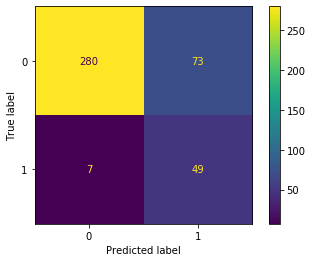

In [23]:
metrics.plot_confusion_matrix(lr, pd.concat([X_test, testprice_dummies, testcat_dummies], axis = 1), y_test)

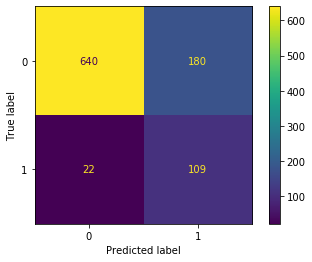

In [24]:
metrics.plot_confusion_matrix(lr, pd.concat([X_train, price_dummies, cat_dummies], axis = 1), y_train)

In [25]:
dtc = DecisionTreeClassifier(random_state=2, max_leaf_nodes=11, max_features=13, class_weight='balanced', criterion='gini')

dtc.fit(pd.concat([X_train, price_dummies, cat_dummies], axis = 1), y_train)

dtc_trainpred = dtc.predict(pd.concat([X_train, price_dummies, cat_dummies], axis = 1))
dtc_testpred = dtc.predict(pd.concat([X_test, testprice_dummies, testcat_dummies], axis = 1))

print(metrics.accuracy_score(y_train, dtc_trainpred))
print(metrics.accuracy_score(y_test, dtc_testpred))

print(metrics.precision_score(y_train, dtc_trainpred))
print(metrics.precision_score(y_test, dtc_testpred))

print(metrics.recall_score(y_train, dtc_trainpred))
print(metrics.recall_score(y_test, dtc_testpred))

# 0.8086225026288117
# 0.7946210268948656
# 0.4105263157894737
# 0.38333333333333336
# 0.8931297709923665
# 0.8214285714285714 rnd 2 mx leaf 11 mx ft 13 balanced gini

0.8086225026288117
0.7946210268948656
0.4105263157894737
0.38333333333333336
0.8931297709923665
0.8214285714285714


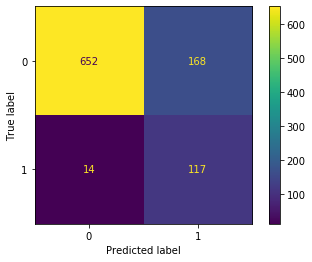

In [26]:
metrics.plot_confusion_matrix(dtc, pd.concat([X_train, price_dummies, cat_dummies], axis = 1), y_train)

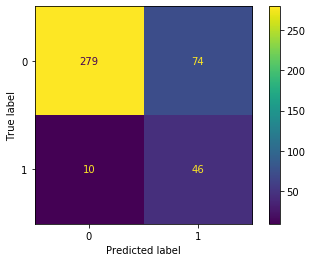

In [27]:
metrics.plot_confusion_matrix(dtc, pd.concat([X_test, testprice_dummies, testcat_dummies], axis = 1), y_test)

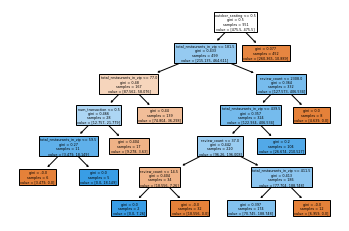

In [28]:
tree.plot_tree(dtc, filled= True, feature_names=X_train_maxft.columns);

In [29]:

tree_data = tree.export_graphviz(dtc, out_file=None, feature_names=X_train_maxft.columns, filled = True, rounded= True, special_characters= True) 
graph = graphviz.Source(tree_data) 

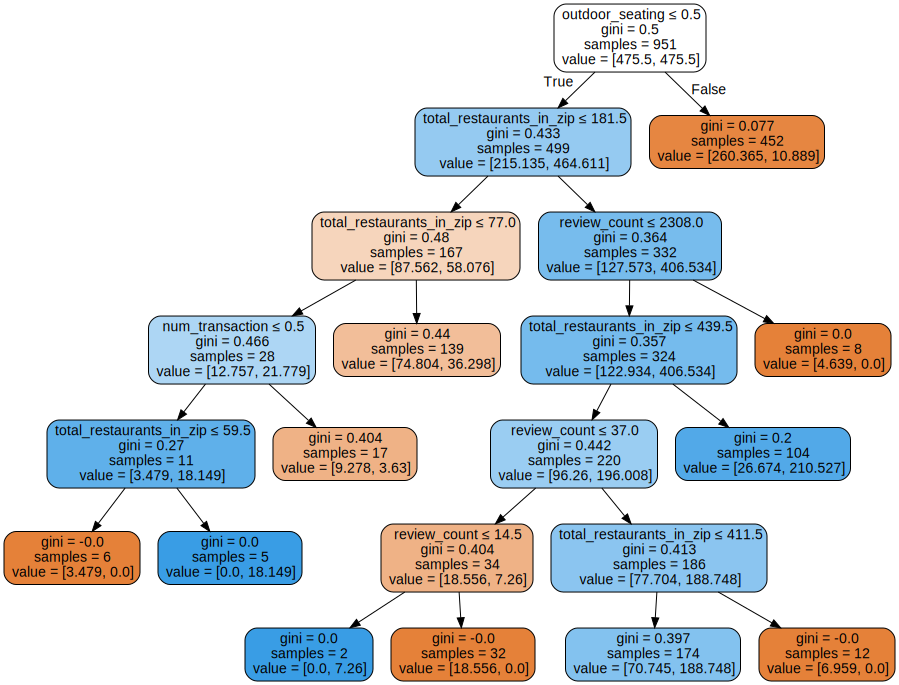

In [30]:
graph

In [45]:
rfc = RandomForestClassifier(random_state=2, max_leaf_nodes=10, max_features=9, class_weight='balanced', n_estimators=500, n_jobs=-1, verbose=1)

rfc.fit(pd.concat([X_train, price_dummies, cat_dummies], axis = 1), y_train)

rfc_trainpred = rfc.predict(pd.concat([X_train, price_dummies, cat_dummies], axis = 1))
rfc_testpred = rfc.predict(pd.concat([X_test, testprice_dummies, testcat_dummies], axis = 1))

print(metrics.accuracy_score(y_train, rfc_trainpred))
print(metrics.accuracy_score(y_test, rfc_testpred))

print(metrics.precision_score(y_train, rfc_trainpred))
print(metrics.precision_score(y_test, rfc_testpred))

print(metrics.recall_score(y_train, rfc_trainpred))
print(metrics.recall_score(y_test, rfc_testpred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
0.8023133543638276
0.784841075794621
0.4033898305084746
0.36885245901639346
0.9083969465648855
0.8035714285714286
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_j

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


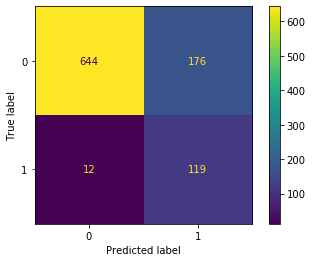

In [46]:
metrics.plot_confusion_matrix(rfc, pd.concat([X_train, price_dummies, cat_dummies], axis = 1), y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


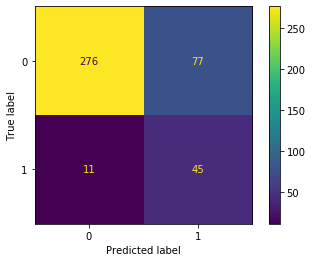

In [47]:
metrics.plot_confusion_matrix(rfc, pd.concat([X_test, testprice_dummies, testcat_dummies], axis = 1), y_test)

In [48]:
print(metrics.f1_score(y_train, rfc_trainpred))
print(metrics.f1_score(y_test, rfc_testpred))

0.5586854460093897
0.5056179775280899


In [ ]:
df.columns

In [ ]:
lrscaled = LogisticRegression(random_state=1, class_weight= 'balanced', penalty='l2', C= 1, solver = 'liblinear')

lrscaled.fit(pd.concat([X_train_scaled, price_dummies, cat_dummies], axis = 1), y_train)

scaled_train_pred = lrscaled.predict(pd.concat([X_train_scaled, price_dummies, cat_dummies], axis = 1))
scaled_test_pred = lrscaled.predict(pd.concat([X_test_scaled, price_dummies, cat_dummies], axis = 1))

print(metrics.accuracy_score(y_train, scaled_train_pred))
print(metrics.accuracy_score(y_test, scaled_test_pred))

print(metrics.precision_score(y_train, scaled_train_pred))
print(metrics.precision_score(y_test, scaled_test_pred))

print(metrics.recall_score(y_train, scaled_train_pred))
print(metrics.recall_score(y_test, scaled_test_pred))